In [273]:
import torch
import scanpy as sc

adata = sc.read_h5ad("/Users/jameshaberberger/GitHub/chinese-restaurant-process/data/adata.h5ad")
adata.X = adata.X.todense()

counts = torch.tensor(adata.X)
counts = counts[counts.sum(axis=1) > 300]
size_factors = (counts.sum(axis=1) / counts.sum(axis=1).mean()).log()

/Users/jameshaberberger/GitHub/chinese-restaurant-process/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


# In Numpy

In [590]:
testing = adata[adata.X.sum(axis=1) > 300].copy()

In [ ]:
sc.pp.normalize_total(testing, target_sum=1e4)
sc.pp.log1p(testing)
sc.pp.pca(testing, n_comps=20)
sc.pp.neighbors(testing, n_neighbors=10, n_pcs=20)
sc.tl.umap(testing, min_dist=0.5, spread=1.0, n_components=2)
sc.pp.highly_variable_genes(testing, subset=False, n_top_genes=100)
sc.tl.leiden(testing, resolution=0.5, key_added="leiden_crp")

In [596]:
counts = testing.X

In [652]:
import numpy as np
from scipy.special import gammaln

class ChineseRestaurantTable:
    """A class representing a table in the Chinese Restaurant Process using NumPy."""

    def __init__(self, data, alpha_prior, beta_prior, prior_strength = 0.1):
        self.data = data  # shape (N, D)
        self.mean_counts = self.data.sum(axis=1).mean()
        self.size_factors = np.log(self.data.sum(axis=1) / self.data.sum(axis=1).mean())

        self.members = set()

        self.prior_strength = prior_strength
        self.alpha_prior_ = alpha_prior * self.prior_strength
        self.beta_prior_ = beta_prior * self.prior_strength

        self.table_alpha = np.zeros_like(alpha_prior)
        self.table_beta = np.zeros_like(beta_prior)

        self.last_updated_epoch = 0
    
    def set_prior_strength(self, prior_strength):
        """Set the prior strength for the table."""
        self.prior_strength = prior_strength
        self.alpha_prior_ = self.alpha_prior_ * prior_strength
        self.beta_prior_ = self.beta_prior_ * prior_strength

    def add_member(self, index, epoch=None):
        self.members.add(index)
        self.table_beta += 1
        self.table_alpha += self.data[index]
        if epoch is not None:
            self.last_updated_epoch = epoch

    def remove_member(self, index):
        if index in self.members:
            self.members.remove(index)
            self.table_beta -= 1
            self.table_alpha -= self.data[index]

    def posterior_alpha(self, index):
        return self.alpha_prior_ + self.table_alpha + self.data[index]

    def posterior_beta(self):
        return self.beta_prior_ + self.table_beta + 1

    @staticmethod
    def log_likelihood(y, alpha, beta, size_factor, eps=1e-6):
        """
        Gamma-Poisson (Negative Binomial) log marginal likelihood with size factor.

        Returns:
        - Scalar: sum over feature dimensions
        """
        alpha = np.clip(alpha, eps, None)
        beta = np.clip(beta, eps, None)
        size_factor = np.clip(size_factor, eps, None)

        r = alpha
        p = 1.0 / (beta + size_factor)
        p = np.clip(p, eps, 1.0 - eps)

        log_coeff = gammaln(y + r) - gammaln(y + 1.0) - gammaln(r)
        log_prob = log_coeff + r * np.log1p(-p) + y * np.log(p)

        return log_prob


    def log_marginal_likelihood(self, index):
        alpha = self.posterior_alpha(index)
        beta = self.posterior_beta()
        y = self.data[index]
        size_factor = self.size_factors[index]
        return self.log_likelihood(y, alpha, beta, size_factor).sum()


In [736]:
import numpy as np
from tqdm import tqdm, trange

class ChineseRestaurantProcess:
    def __init__(self, data: np.ndarray, expected_classes: int = 10):
        self.data = data
        self.set_prior()

        self.classes = {}
        self.assignments = [-1] * data.shape[0]

        self.expected_classes = expected_classes
        self._alpha = expected_classes / np.log(data.shape[0])

    def set_prior(self):
        mean = self.data.mean(axis=0)
        var = self.data.var(axis=0)
        self.alpha_prior_ = np.where(var > 0, mean**2 / var, 1.0)
        self.beta_prior_ = np.where(var > 0, mean / var, 1.0)

    def generate_new_table(self):
        return ChineseRestaurantTable(self.data, self.alpha_prior_, self.beta_prior_)

    def add_table(self, table, index=None):
        new_class_id = 0
        while new_class_id in self.classes:
            new_class_id += 1
        self.classes[new_class_id] = table
        if index is not None:
            table.add_member(index)
        return new_class_id

    def remove_table(self, class_id):
        if class_id in self.classes:
            for member in self.classes[class_id].members:
                self.assignments[member] = -1
            del self.classes[class_id]
        else:
            raise ValueError(f"Class ID {class_id} does not exist.")

    def run(self, epochs=1, max_classes=100, min_membership=0.01):
        for epoch in range(epochs):
            for i in tqdm(np.random.permutation(self.data.shape[0])):
                x_i = self.data[i]

                # Generate new table for this round
                crp_new = self.generate_new_table()

                # Existing class log-likelihoods
                cluster_keys = list(self.classes.keys()) + ["new"]
                nlls = []
                for k in self.classes:
                    table = self.classes[k]
                    log_like = table.log_marginal_likelihood(i)
                    log_prior = np.log1p(len(table.members))
                    nlls.append(log_like + log_prior)

                # New table likelihood
                log_new = crp_new.log_marginal_likelihood(i) + np.log(self._alpha)
                nlls.append(log_new)

                # Softmax sampling
                probs = np.exp(nlls - np.max(nlls))  # stability
                probs /= probs.sum()
                sampled_idx = np.random.choice(len(probs), p=probs)
                sampled_class = cluster_keys[sampled_idx]

                # Assignment
                if sampled_class == "new":
                    new_table = self.generate_new_table()
                    new_table.add_member(i, epoch)
                    self.add_table(new_table, i)
                else:
                    self.classes[sampled_class].add_member(i, epoch)
                    self.assignments[i] = int(sampled_class)

            # After epoch: remove empty tables
            to_remove = [k for k, v in self.classes.items() if len(v.members) <= min_membership * self.data.shape[0]]
            for k in to_remove:
                self.remove_table(k)


    def predict(self, new_data: np.ndarray, min_membership: float = 0.01):
        """
        Vectorized prediction of class assignments for new data points.

        Parameters:
        - new_data: (M, D) array of new observations
        - min_membership: fraction of total training data required to consider a class

        Returns:
        - predictions: (M,) array of class IDs (or -1 if none eligible)
        """
        total_members = sum(len(t.members) for t in self.classes.values())
        cutoff = total_members * min_membership

        # Filter eligible classes
        eligible = [(k, t) for k, t in self.classes.items() if len(t.members) >= cutoff]
        if not eligible:
            return np.full(new_data.shape[0], -1, dtype=int)

        class_ids = np.array([k for k, _ in eligible])
        table_sums = np.stack([t.table_alpha for _, t in eligible])   # shape (K, D)
        table_counts = np.array([t.table_beta[0] for _, t in eligible])  # scalar per class
        class_sizes = np.array([len(t.members) for _, t in eligible])    # prior weight

        # Get priors
        alpha_prior = self.alpha_prior_[None, :]   # shape (1, D)
        beta_prior = self.beta_prior_[None, :]

        # Mean for size factor calc
        mean_sum = self.data.sum(axis=1).mean()

        M, D = new_data.shape
        K = len(eligible)
        predictions = np.full(M, -1, dtype=int)

        for i in trange(M):
            x_i = new_data[i]
            sf = np.log(x_i.sum() / mean_sum)

            alpha_post = alpha_prior + table_sums + x_i  # shape (K, D)
            beta_post = beta_prior + table_counts[:, None] + 1  # shape (K, D)
            r = alpha_post
            p = 1.0 / (beta_post + sf)
            p = np.clip(p, 1e-6, 1 - 1e-6)

            # Compute log-likelihood vectorized over K
            y = x_i[None, :]  # (1, D)
            log_coeff = gammaln(y + r) - gammaln(y + 1) - gammaln(r)
            log_prob = log_coeff + r * np.log(1 - p) + y * np.log(p)
            total_log_like = log_prob.sum(axis=1)  # shape (K,)

            log_prior = np.log(class_sizes + 1e-6)
            scores = total_log_like + log_prior

            predictions[i] = class_ids[np.argmax(scores)]

        return predictions


In [737]:
crp = ChineseRestaurantProcess(counts[::5], expected_classes=1)
crp.run(epochs=5)

 24%|██▎       | 864/3664 [00:02<00:08, 340.23it/s]


KeyboardInterrupt: 

In [738]:
labels = crp.predict(counts, min_membership=0.01)

# Assume labels is a list or array-like of cluster assignments (e.g. [3, 3, 7, 2, 7])
labels = pd.Series(labels)
testing.obs["crp_labels"] = labels.tolist()
testing.obs["crp_labels"].value_counts()

100%|██████████| 18318/18318 [00:07<00:00, 2429.14it/s]


crp_labels
0      2358
63     1038
70      935
18      788
30      734
111     670
24      654
7       642
4       585
82      578
60      573
73      560
8       555
55      549
28      519
10      510
47      510
56      481
15      458
21      452
12      421
50      384
26      331
20      330
49      325
17      289
9       286
71      283
84      257
14      230
2       213
5       212
35      206
29      205
45      197
Name: count, dtype: int64

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

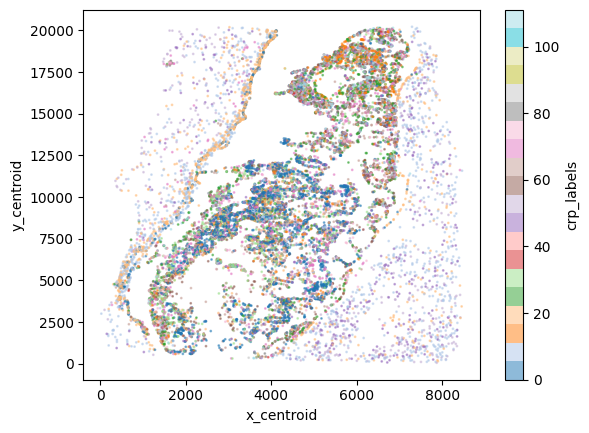

In [740]:
testing.obs.plot.scatter(x="x_centroid", y="y_centroid", c="crp_labels", colormap="tab20", s=1, alpha=0.5)

/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_28546/999079070.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  testing.obs.pivot_table(index="crp_labels", columns="Cell.Subtype", values="x_centroid", aggfunc="count"),


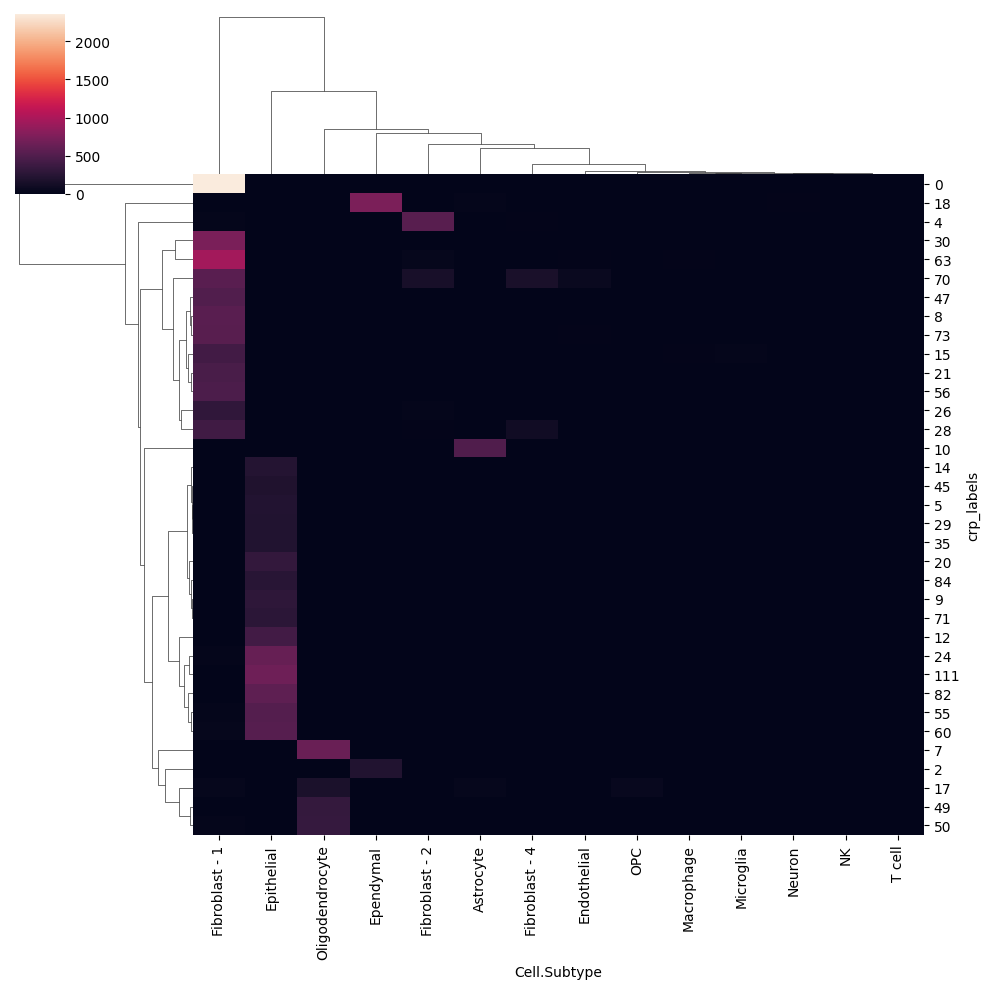

In [741]:
import seaborn as sns
sns.clustermap(
    testing.obs.pivot_table(index="crp_labels", columns="Cell.Subtype", values="x_centroid", aggfunc="count"),
)

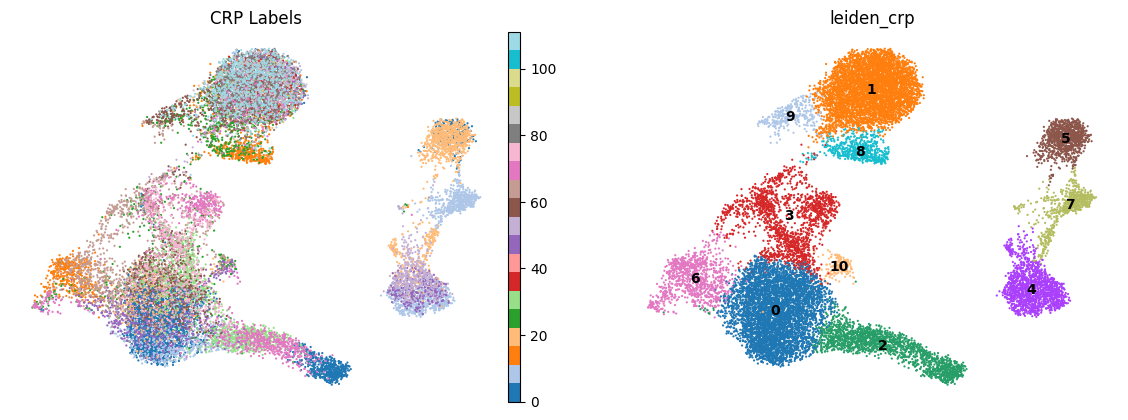

In [742]:
sc.pl.umap(testing, color=["crp_labels", "leiden_crp"], frameon=False, size=10, alpha=1, legend_loc="on data", title="CRP Labels", cmap='tab20')

# Issues

Too much fragmentation, but we also can't just try to merge things. At that point, why even bother with Bayesian Nonparametrics? The whole point is that it infers structure, and if we tell it the structure then I may as well just fiddle with a resolution parameter in leiden clustering. Something better.